In [1]:
import os
import re
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image, ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Embedding, LSTM, TimeDistributed, Reshape,
                                     Multiply, Activation, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from collections import Counter
import math
import random

In [2]:
DATA_ROOT = "./mathwriting-2024"          # root where train/ valid/ test/ folders are located
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VALID_DIR = os.path.join(DATA_ROOT, "valid")
TEST_DIR = os.path.join(DATA_ROOT, "test")  # optional

IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2

BATCH_SIZE = 64
EPOCHS = 10
SHUFFLE_BUFFER = 2000

MAX_OUTPUT_TOKENS = 120   # max tokens for output sequences (incl <START>, <END>)
EMBED_DIM = 128
DEC_UNITS = 256
ATTN_UNITS = 256
VOCAB_OOV_TOKEN = "<UNK>"

BEAM_WIDTH = 3            # for inference beam search

AUTOTUNE = tf.data.AUTOTUNE

XML_NS = "{http://www.w3.org/2003/InkML}"

In [3]:
def parse_inkml_traces(inkml_path):
    """Return list of traces; each trace is list of (x,y) floats."""
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        text = trace.text or ""
        pts = []
        for part in text.strip().split(','):
            part = part.strip()
            if not part:
                continue
            coords = part.split()
            if len(coords) >= 2:
                try:
                    x = float(coords[0])
                    y = float(coords[1])
                except:
                    continue
                pts.append((x, y))
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces, out_size=IMG_SIZE, padding=PADDING):
    if not traces:
        return []
    xs = [x for tr in traces for (x, y) in tr]
    ys = [y for tr in traces for (x, y) in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width = maxx - minx if maxx - minx != 0 else 1.0
    height = maxy - miny if maxy - miny != 0 else 1.0
    avail = out_size - 2 * padding
    scale = avail / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx) * scale + padding, (y - miny) * scale + padding) for (x, y) in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces, size=IMG_SIZE, stroke_width=STROKE_WIDTH):
    img = Image.new("L", (size, size), color=255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x - stroke_width, y - stroke_width, x + stroke_width, y + stroke_width], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i - 1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=stroke_width)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # invert so strokes=1.0
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces, out_size=IMG_SIZE, padding=PADDING)
    img = render_traces_to_image(norm, size=IMG_SIZE, stroke_width=STROKE_WIDTH)
    return img


In [4]:
token_pattern = re.compile(r"""
    (\\[A-Za-z]+)        |   # LaTeX command like \frac
    ([{}^_])             |   # braces and supers/subscript symbols
    (\d+\.\d+|\d+)       |   # numbers
    ([A-Za-z]+)          |   # letters (variables)
    (<=|>=|==|!=|->|<-|\\in|\\notin) | # multi-char operators / some commands
    ([+\-*/=(),\[\].:;%]) |  # punctuation/operators
    (\\.)                |   # other backslash escapes like \{
    (\S)                     # any other non-whitespace char
""", re.VERBOSE)

def tokenize_latex_lite(s):
    if s is None:
        return []
    s = s.strip()
    if s == "":
        return []
    # Make sure backslashes are kept intact (avoid splitting like "\frac" into "\" and "frac")
    tokens = []
    for m in token_pattern.finditer(s):
        tok = m.group(0)
        tokens.append(tok)
    return tokens

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return "<EMPTY>"
    # Some basic normalization: collapse spaces, keep backslashes
    return " ".join(tokenize_latex_lite(label))

In [5]:
def build_file_label_list(folder):
    files = []
    labels = []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None and ann.text else ""
        except Exception:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

print("Listing files (this may take a few seconds)...")
train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)
print(f"Train samples: {len(train_files)}, Valid samples: {len(valid_files)}")


Listing files (this may take a few seconds)...
Train samples: 229864, Valid samples: 15674


In [6]:
all_texts = train_labels + valid_labels
tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = len(word_index) + 1
print("Vocab size:", vocab_size)

Vocab size: 5700


In [7]:
def encode_label_to_sequence(label):
    seq = tokenizer.texts_to_sequences([label])[0]
    seq = seq[:MAX_OUTPUT_TOKENS-1]  # reserve space for <END> if any
    # add <START> and <END> if not present token-wise
    # Our labels already include tokens; we ensure start/end
    start_idx = word_index.get("<START>")
    end_idx = word_index.get("<END>")
    if start_idx is None:
        # add markers if tokenizer didn't see them
        seq = [word_index.get(VOCAB_OOV_TOKEN, 1)] + seq
    else:
        seq = [start_idx] + seq
    if end_idx is None:
        seq = seq + [word_index.get(VOCAB_OOV_TOKEN, 1)]
    else:
        seq = seq + [end_idx]
    # pad to MAX_OUTPUT_TOKENS
    seq = pad_sequences([seq], maxlen=MAX_OUTPUT_TOKENS, padding='post')[0]
    return seq

def gen_example(file_path, label):
    # returns: (image array float32 [H,W,1], label sequence int32 length MAX_OUTPUT_TOKENS)
    img = inkml_to_image_array(file_path)  # float32 [H,W]
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label).astype(np.int32)
    return img, seq

# wrappers for tf.data
def tf_load_and_preprocess(path, label):
    # path: tf string; label: tf string
    # Use tf.py_function to call Python preprocessing (InkML rasterization)
    img, seq = tf.py_function(func=lambda p, l: gen_example(p.numpy().decode('utf-8'), l.numpy().decode('utf-8')),
                              inp=[path, label],
                              Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_dataset(file_list, label_list, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((file_list, label_list))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(file_list), SHUFFLE_BUFFER))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, train_labels, batch=BATCH_SIZE, shuffle=True)
valid_ds = make_dataset(valid_files, valid_labels, batch=BATCH_SIZE, shuffle=False)


In [16]:
def build_models(img_h=IMG_SIZE, img_w=IMG_SIZE, channels=1,
                 vocab_size=vocab_size, embed_dim=EMBED_DIM,
                 dec_units=DEC_UNITS, attn_units=ATTN_UNITS,
                 max_out_tokens=MAX_OUTPUT_TOKENS):
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, Embedding, LSTM, Concatenate, Lambda
    from tensorflow.keras.models import Model
    import tensorflow as tf
    from tensorflow.keras.optimizers import Adam

    # ---------------- Encoder ----------------
    img_input = Input(shape=(img_h, img_w, channels), name='img_input')
    x = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    shape = tf.keras.backend.int_shape(x)
    Hf, Wf, Cf = shape[1], shape[2], shape[3]
    feat_seq = Reshape((Hf*Wf, Cf))(x)
    feat_proj = Dense(dec_units, activation='tanh')(feat_seq)
    encoder_model = Model(img_input, feat_proj, name='encoder_model')

    # ---------------- Decoder ----------------
    decoder_inputs = Input(shape=(max_out_tokens,), name='decoder_inputs')
    emb = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True, name='decoder_embedding')(decoder_inputs)

    decoder_lstm = LSTM(dec_units, return_sequences=True, return_state=True, name='decoder_lstm')
    lstm_outputs, _, _ = decoder_lstm(emb)  # LSTM handles zeros internally

    # ---------------- Attention ----------------
    W1 = Dense(attn_units, use_bias=False, name='attn_W1')
    W2 = Dense(attn_units, use_bias=False, name='attn_W2')
    V  = Dense(1, use_bias=False, name='attn_V')

    def apply_attention(feat, dec_h):
        w1 = W1(feat)
        w2 = W2(dec_h)
        w1_exp = tf.expand_dims(w1, axis=1)
        w2_exp = tf.expand_dims(w2, axis=2)
        score = V(tf.nn.tanh(w1_exp + w2_exp))
        score = tf.squeeze(score, axis=-1)
        attn_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attn_weights, feat)
        return context, attn_weights

    context_vectors, attn_weights = Lambda(lambda args: apply_attention(args[0], args[1]),
                                           name='attention')([feat_proj, lstm_outputs])

    concat = Concatenate(axis=-1)([lstm_outputs, context_vectors])
    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(concat)

    full_model = Model([img_input, decoder_inputs], decoder_outputs, name='train_model')
    full_model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    inference_layers = {
        'W1': W1, 'W2': W2, 'V': V,
        'decoder_embedding_layer': full_model.get_layer('decoder_embedding'),
        'decoder_lstm_layer': decoder_lstm,
        'decoder_dense_layer': decoder_dense
    }

    return full_model, encoder_model, inference_layers

# Build models
print("Building models...")
train_model, encoder_model, inference_layers = build_models()
train_model.summary()


Building models...


d:\OCR_MATH\venv\lib\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'attention' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "train_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        320 │ img_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 120, 128)  │    729,600 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 120)       │          0 │ decoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 256, 128)  │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 120,      │    394,240 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ not_equal_3[0][0] │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256, 256)  │     33,024 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention (Lambda)  │ [(None, 120,      │          0 │ dense_3[0][0],    │
│                     │ 256), (None, 120, │            │ decoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 120, 512)  │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 120, 5700) │  2,924,100 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 4,173,636 (15.92 MB)

 Trainable params: 4,173,636 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def make_training_dataset(file_list, label_list, batch=BATCH_SIZE, shuffle=True):
    ds_files = tf.data.Dataset.from_tensor_slices((file_list, label_list))
    if shuffle:
        ds_files = ds_files.shuffle(buffer_size=min(len(file_list), SHUFFLE_BUFFER))
    
    ds = ds_files.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    # ds yields (img, seq)

    def prepare_for_training(img, seq):
        seq = tf.cast(seq, tf.int32)
        decoder_input = seq[:-1]
        decoder_target = seq[1:]

        # pad to MAX_OUTPUT_TOKENS
        decoder_input = tf.pad(decoder_input, [[0, MAX_OUTPUT_TOKENS - tf.shape(decoder_input)[0]]])
        decoder_target = tf.pad(decoder_target, [[0, MAX_OUTPUT_TOKENS - tf.shape(decoder_target)[0]]])

        decoder_target = tf.expand_dims(decoder_target, -1)  # shape: (MAX_OUTPUT_TOKENS, 1)
        return (img, decoder_input), decoder_target

    ds = ds.map(prepare_for_training, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

# Create datasets
train_ds_tf = make_training_dataset(train_files, train_labels, batch=BATCH_SIZE, shuffle=True)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, batch=BATCH_SIZE, shuffle=False)


In [19]:
print("Starting training...")
train_model.fit(train_ds_tf, validation_data=valid_ds_tf, epochs=EPOCHS)

Starting training...
Epoch 1/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 6642s 2s/step - accuracy: 0.9030 - loss: 0.5091 - val_accuracy: 0.9301 - val_loss: 0.3434
Epoch 2/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 6581s 2s/step - accuracy: 0.9316 - loss: 0.3354 - val_accuracy: 0.9385 - val_loss: 0.2940
Epoch 3/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 6576s 2s/step - accuracy: 0.9389 - loss: 0.2928 - val_accuracy: 0.9424 - val_loss: 0.2718
Epoch 4/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 6589s 2s/step - accuracy: 0.9423 - loss: 0.2710 - val_accuracy: 0.9443 - val_loss: 0.2600
Epoch 5/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 7314s 2s/step - accuracy: 0.9443 - loss: 0.2574 - val_accuracy: 0.9456 - val_loss: 0.2515
Epoch 6/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 7659s 2s/step - accuracy: 0.9458 - loss: 0.2473 - val_accuracy: 0.9466 - val_loss: 0.2450
Epoch 7/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 6730s 2s/step - accuracy: 0.9471 - loss: 0.2390 - val_accuracy: 0.9477 - val_loss: 0.2394
Epoch 8/10
3592/3592 ━━━━━━━━━━━━━━━━━━━━ 8055s 2s/step

In [25]:
train_model.save("math_ocr.h5")
print("Model saved to math ocr.h5")

Model saved to math ocr.h5


In [49]:
# Save model using the .keras format (recommended)
train_model.save("math_ocr.keras")
print("Model saved to math_ocr.keras")


Model saved to math_ocr.keras


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import re

# -------------------- GPU setup --------------------
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU enabled for TensorFlow")
    except:
        print("⚠️ Could not set GPU memory growth")
else:
    print("⚠️ No GPU detected, using CPU")

# -------------------- Config --------------------
IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2
MAX_OUTPUT_TOKENS = 120
XML_NS = "{http://www.w3.org/2003/InkML}"

# -------------------- Utility functions --------------------
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords)>=2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces: return []
    xs = [x for tr in traces for x,y in tr]
    ys = [y for tr in traces for x,y in tr]
    minx,maxx = min(xs), max(xs)
    miny,maxy = min(ys), max(ys)
    width,height = maxx-minx,maxy-miny
    width,height = width if width>0 else 1, height if height>0 else 1
    scale = (IMG_SIZE-2*PADDING)/max(width,height)
    norm = []
    for tr in traces:
        pts = [((x-minx)*scale+PADDING, (y-miny)*scale+PADDING) for x,y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L",(IMG_SIZE,IMG_SIZE),255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr)==1:
            x,y=tr[0]
            draw.ellipse([x-STROKE_WIDTH,y-STROKE_WIDTH,x+STROKE_WIDTH,y+STROKE_WIDTH], fill=0)
        else:
            for i in range(1,len(tr)):
                x1,y1=tr[i-1]; x2,y2=tr[i]
                draw.line([x1,y1,x2,y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32)/255.0
    arr = 1.0 - arr
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE,IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# -------------------- Tokenizer setup --------------------
# Use the same tokenizer used during training
import pickle
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
word_index = tokenizer.word_index
index_word = {v:k for k,v in word_index.items()}
vocab_size = len(word_index)+1

# -------------------- Load model --------------------
model = load_model("math_ocr_improved.h5", compile=False)
print("✅ Model loaded successfully")

# -------------------- Inference function --------------------
def predict_latex(inkml_path, max_tokens=MAX_OUTPUT_TOKENS):
    img = inkml_to_image_array(inkml_path)
    img = np.expand_dims(img,-1)  # (H,W,1)
    img = np.expand_dims(img,0)   # (1,H,W,1) batch dimension

    # Greedy decoding
    start_token = word_index.get("<START>",1)
    end_token = word_index.get("<END>",2)
    seq = [start_token]

    for _ in range(max_tokens):
        dec_input = pad_sequences([seq], maxlen=MAX_OUTPUT_TOKENS, padding='post')
        preds = model.predict([img, dec_input], verbose=0)
        next_id = np.argmax(preds[0,len(seq)-1,:])
        seq.append(next_id)
        if next_id==end_token:
            break

    tokens = [index_word.get(i,"<UNK>") for i in seq if i not in [start_token,end_token]]
    return " ".join(tokens)



In [ ]:
# -------------------- Test --------------------
sample_file = "./mathwriting-2024/test/sample.inkml"  # change to your test file
predicted_latex = predict_latex(sample_file)
print("Predicted LaTeX:", predicted_latex)


In [3]:
!pip install pillow


     ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.0 MB 1.3 MB/s eta 0:00:06
      --------------------------------------- 0.1/7.0 MB 1.8 MB/s eta 0:00:04
     -- ------------------------------------- 0.4/7.0 MB 4.6 MB/s eta 0:00:02
     ------ --------------------------------- 1.1/7.0 MB 7.1 MB/s eta 0:00:01
     ---------- ----------------------------- 1.8/7.0 MB 8.7 MB/s eta 0:00:01
     ------------- -------------------------- 2.4/7.0 MB 9.6 MB/s eta 0:00:01
     ---------------- ----------------------- 2.9/7.0 MB 9.7 MB/s eta 0:00:01
     --------------------- ------------------ 3.7/7.0 MB 10.8 MB/s eta 0:00:01
     ------------------------ --------------- 4.4/7.0 MB 11.6 MB/s eta 0:00:01
     ---------------------------- ----------- 5.0/7.0 MB 11.4 MB/s eta 0:00:01
     --------------------------------- ------ 5.9/7.0 MB 12.1 MB/s eta 0:00:01
     ------------------------------------ --- 6.4/7.0 MB 12.0 MB/s 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os
import re
from glob import glob
import xml.etree.ElementTree as ET

import numpy as np
from PIL import Image, ImageDraw

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense,
                                     Embedding, LSTM, Concatenate, Attention)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:

# -------------------- Config --------------------
DATA_ROOT = "./mathwriting-2024"  # change to your dataset root
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VALID_DIR = os.path.join(DATA_ROOT, "valid")

IMG_SIZE = 128
PADDING = 8
STROKE_WIDTH = 2

BATCH_SIZE = 32
EPOCHS = 2

MAX_OUTPUT_TOKENS = 120   # includes START and END
DECODER_SEQ_LEN = MAX_OUTPUT_TOKENS - 1  # decoder input length (without last target shift)
EMBED_DIM = 128
DEC_UNITS = 256
ATTN_UNITS = 256
VOCAB_OOV_TOKEN = "<UNK>"
AUTOTUNE = tf.data.AUTOTUNE
XML_NS = "{http://www.w3.org/2003/InkML}"

# Special tokens
START_TOKEN = "<START>"
END_TOKEN = "<END>"
EMPTY_TOKEN = "<EMPTY>"

In [10]:
# -------------------- Utility Functions --------------------
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except Exception:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        text = trace.text or ""
        # some traces have newlines/spaces; split by commas
        for part in text.strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except Exception:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx - minx, maxy - miny
    width, height = (width if width > 0 else 1), (height if height > 0 else 1)
    scale = (IMG_SIZE - 2 * PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx) * scale + PADDING, (y - miny) * scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x - STROKE_WIDTH, y - STROKE_WIDTH, x + STROKE_WIDTH, y + STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i - 1]; x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr  # invert: background 0, strokes 1
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# -------------------- Tokenizer / Tokenization --------------------
token_pattern = re.compile(
    r"(\\[A-Za-z]+)|([{}^_])|(\d+\.\d+|\d+)|([A-Za-z]+)|([+\-*/=(),\[\].:;%])|(\\.)|(\S)",
    re.VERBOSE
)

def tokenize_latex_lite(s):
    if not s:
        return []
    return [m.group(0) for m in token_pattern.finditer(s)]

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return EMPTY_TOKEN
    return " ".join(tokenize_latex_lite(label.strip()))

def build_file_label_list(folder):
    files, labels = [], []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None and ann.text else ""
        except Exception:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

# -------------------- Load file lists --------------------
train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)
print(f"Train samples: {len(train_files)}, Valid samples: {len(valid_files)}")

# Build tokenizer ensuring special tokens are included
all_texts = [t if t and t.strip() else EMPTY_TOKEN for t in (train_labels + valid_labels)]
# ensure START/END tokens included in tokenizer's vocabulary
all_texts.append(START_TOKEN)
all_texts.append(END_TOKEN)

tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}
vocab_size = len(word_index) + 1

print("Vocab size:", vocab_size)
print("Index START/END:", word_index.get(START_TOKEN), word_index.get(END_TOKEN))

Train samples: 229864, Valid samples: 15674
Vocab size: 5696
Index START/END: 5694 5695


In [11]:
# -------------------- Encoding --------------------
def encode_label_to_sequence(label):
    if not label or label.strip() == "":
        label = EMPTY_TOKEN
    # convert to sequence of ids (body tokens)
    body = tokenizer.texts_to_sequences([label])[0]
    # reserve room for START and END
    max_body = MAX_OUTPUT_TOKENS - 2
    body = body[:max_body]
    start_idx = word_index[START_TOKEN]
    end_idx = word_index[END_TOKEN]
    seq = [start_idx] + body + [end_idx]
    # pad to MAX_OUTPUT_TOKENS
    seq = pad_sequences([seq], maxlen=MAX_OUTPUT_TOKENS, padding='post', truncating='post')[0]
    return seq.astype(np.int32)

# -------------------- Dataset pipeline --------------------
def gen_example(file_path, label):
    img = inkml_to_image_array(file_path)
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label)
    return img, seq

def tf_load_and_preprocess(path, label):
    img, seq = tf.py_function(
        func=lambda p, l: gen_example(p.decode('utf-8'), l.decode('utf-8')),
        inp=[path, label],
        Tout=[tf.float32, tf.int32]
    )
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_training_dataset(files, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 2000))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)

    def prepare(img, seq):
        # decoder input is seq[:-1], target is seq[1:]
        decoder_input = seq[:-1]   # length MAX_OUTPUT_TOKENS-1
        decoder_target = seq[1:]   # length MAX_OUTPUT_TOKENS-1
        decoder_target = tf.expand_dims(decoder_target, -1)  # (timesteps, 1)
        return (img, decoder_input), decoder_target

    ds = ds.map(prepare, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_tf = make_training_dataset(train_files, train_labels)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, shuffle=False)

In [12]:
# -------------------- Model definition --------------------
def build_models():
    # Encoder
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="img_input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Convert conv features to a sequence (encoder timesteps)
    Hf, Wf, Cf = tf.keras.backend.int_shape(x)[1:]
    feat_seq = Reshape((Hf * Wf, Cf))(x)  # (batch, enc_steps, Cf)
    feat_proj = Dense(DEC_UNITS, activation='tanh', name="feat_proj")(feat_seq)  # (batch, enc_steps, DEC_UNITS)

    encoder_model = Model(img_input, feat_proj, name="encoder")

    # Decoder (training-time, teacher forcing)
    decoder_inputs = Input(shape=(DECODER_SEQ_LEN,), name="decoder_inputs")
    emb = Embedding(vocab_size, EMBED_DIM, mask_zero=True, name="embed")(decoder_inputs)
    lstm_out, _, _ = LSTM(DEC_UNITS, return_sequences=True, return_state=True, name="decoder_lstm")(emb)

    # Attention: query=lstm_out (dec timesteps), value=feat_proj (enc timesteps)
    attention = Attention(use_scale=True, name="attention_layer")
    context = attention([lstm_out, feat_proj])  # (batch, dec_steps, DEC_UNITS)
    concat = Concatenate(axis=-1)([lstm_out, context])  # (batch, dec_steps, 2*DEC_UNITS)
    outputs = Dense(vocab_size, activation='softmax', name="pred_dense")(concat)  # (batch, dec_steps, vocab)

    full_model = Model([img_input, decoder_inputs], outputs, name="full_seq_model")
    full_model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return full_model, encoder_model

train_model, encoder_model = build_models()
train_model.summary()

# -------------------- Greedy inference utility --------------------
# We'll use the training model as predictor: feed encoder image + current decoder_input sequence
def greedy_decode(train_model, encoder_model, image_array, max_steps=DECODER_SEQ_LEN):
    # image_array: (IMG_SIZE, IMG_SIZE) or (IMG_SIZE, IMG_SIZE, 1)
    if image_array.ndim == 2:
        image_array = np.expand_dims(image_array, -1)
    enc_feats = encoder_model.predict(np.expand_dims(image_array, 0))  # (1, enc_steps, DEC_UNITS)

    start_idx = word_index[START_TOKEN]
    end_idx = word_index[END_TOKEN]

    # decoder input initialized to zeros with start token first
    dec_input = np.zeros((1, DECODER_SEQ_LEN), dtype=np.int32)
    dec_input[0, 0] = start_idx

    out_ids = []
    for t in range(max_steps):
        # get predictions for all decoder timesteps; we will look at timestep t
        preds = train_model.predict([np.expand_dims(image_array, 0), dec_input], verbose=0)  # shape (1, dec_steps, vocab)
        step_probs = preds[0, t]   # (vocab,)
        next_id = int(np.argmax(step_probs))
        if next_id == 0:
            # 0 is padding; if model returns padding, break
            break
        if next_id == end_idx:
            break
        out_ids.append(next_id)
        # put predicted token into decoder input for next step
        if t + 1 < DECODER_SEQ_LEN:
            dec_input[0, t + 1] = next_id
    # map ids to tokens
    out_tokens = [index_word.get(i, VOCAB_OOV_TOKEN) for i in out_ids]
    return " ".join(out_tokens)

Model: "full_seq_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['img_input[0][0]']           
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           18496     ['max_pooling2d[0

In [23]:
import os
import numpy as np
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras import layers, models

# --------------------------
# 1. Parse InkML file → (image, label sequence)
# --------------------------
def parse_inkml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # extract strokes (mock: just random array for now)
    img = np.random.rand(64, 64)  # you can replace this with real rendering

    # extract labels (mock: suppose "2+2")
    labels = [2, 10, 2]  # Example encoding (vocab indices)
    return img, labels

# --------------------------
# 2. Load a few samples
# --------------------------
dataset_dir = "sample"
files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith(".inkml")]

images, sequences = [], []
for f in files[:5]:
    img, seq = parse_inkml(f)
    images.append(img)
    sequences.append(seq)

images = np.array(images)[..., np.newaxis]   # (batch, 64,64,1)

# Pad sequences for batch
max_len = max(len(s) for s in sequences)
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding='post')

print("images:", images.shape)
print("sequences:", sequences.shape)

# --------------------------
# 3. Define vocabulary size (very important!)
# --------------------------
vocab_size = int(np.max(sequences)) + 1   # ensures labels fit in [0, vocab_size)

# --------------------------
# 4. Build tiny CNN+Dense model
# --------------------------
model = models.Sequential([
    layers.Input(shape=(64,64,1)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(vocab_size, activation='softmax')   # MATCH vocab size
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

# --------------------------
# 5. Train sanity check (only on first symbol of each sequence)
# --------------------------
y_first = sequences[:, 0]   # first token of each equation
print("y_first:", y_first)

model.fit(images, y_first, epochs=1, verbose=1)

print("✅ Tiny sanity check passed! Model runs with .inkml data.")


images: (5, 64, 64, 1)
sequences: (5, 3)
y_first: [2 2 2 2 2]
1/1 [==============================] - 1s 763ms/step - loss: 2.7197
✅ Tiny sanity check passed! Model runs with .inkml data.


In [25]:
!pip install matplotlib

  Using cached matplotlib-3.10.6-cp310-cp310-win_amd64.whl (8.1 MB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
     ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.3 MB 1.7 MB/s eta 0:00:02
     --- ------------------------------------ 0.2/2.3 MB 2.5 MB/s eta 0:00:01
     -------- ------------------------------- 0.5/2.3 MB 4.0 MB/s eta 0:00:01
     ------------- -------------------------- 0.7/2.3 MB 4.3 MB/s eta 0:00:01
     ----------------- ---------------------- 1.0/2.3 MB 4.5 MB/s eta 0:00:01
     ---------------------- ----------------- 1.3/2.3 MB 4.7 MB/s eta 0:00:01
     --------------------------- ------------ 1.6/2.3 MB 5.0 MB/s eta 0:00:01
     ------------------------------- -------- 1.8/2.3 MB 4.9 MB/s eta 0:00:01
     -------------------------------- ------- 1.9/2.3 MB 4.6 MB/s eta 0:00:01
     -------------------------------------- - 2.2/2.3 MB 4.8 MB/s eta 0:00:01
     ----------


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
!pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
!pip install numpy==1.25.2


     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
     ---------------------------------------- 0.2/15.6 MB 2.3 MB/s eta 0:00:07
     - -------------------------------------- 0.4/15.6 MB 3.9 MB/s eta 0:00:04
     - -------------------------------------- 0.7/15.6 MB 4.6 MB/s eta 0:00:04
     -- ------------------------------------- 0.8/15.6 MB 4.1 MB/s eta 0:00:04
     -- ------------------------------------- 1.1/15.6 MB 4.3 MB/s eta 0:00:04
     --- ------------------------------------ 1.2/15.6 MB 4.4 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/15.6 MB 3.9 MB/s eta 0:00:04
     --- ------------------------------------ 1.5/15.6 MB 4.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/15.6 MB 3.7 MB/s eta 0:00:04
     ---- ----------------------------------- 1.7/15.6 MB 3.8 MB/s eta 0:00:04
     ---- ----------------------------------- 1.9/15.6 MB 3.5 MB/s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.25.2 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
!pip install pandas
!pip install scikit-learn
!pip install pillow


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
     --------------------------------------- 0.0/11.3 MB 991.0 kB/s eta 0:00:12
     ---------------------------------------- 0.1/11.3 MB 1.4 MB/s eta 0:00:08
     - -------------------------------------- 0.4/11.3 MB 2.9 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/11.3 MB 3.5 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/11.3 MB 3.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/11.3 MB 3.6 MB/s eta 0:00:03
     ---- ----------------------------------- 1.2/11.3 MB 4.0 MB/s eta 0:00:03
     ----- ---------------------------------- 1.6/11.3 MB 4.4 MB/s eta 0:00:03
     ------ --------------------------------- 1.8/11.3 MB 4.5 MB/s eta 0:00:03
     ------- -------------------------------- 2.2/11.3 MB 4.9 MB/s eta 0:00:02
     -------- ------------------------------- 2.5/11.3 MB 4.9 MB/s eta 0:00:02
     ---------- ----------------------------- 3.0/11.3 MB


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
!pip install lxml

     ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
      --------------------------------------- 0.1/4.0 MB 871.5 kB/s eta 0:00:05
     - -------------------------------------- 0.2/4.0 MB 1.5 MB/s eta 0:00:03
     --- ------------------------------------ 0.3/4.0 MB 2.2 MB/s eta 0:00:02
     ----- ---------------------------------- 0.6/4.0 MB 2.9 MB/s eta 0:00:02
     -------- ------------------------------- 0.8/4.0 MB 3.7 MB/s eta 0:00:01
     ---------- ----------------------------- 1.1/4.0 MB 3.8 MB/s eta 0:00:01
     ------------- -------------------------- 1.3/4.0 MB 4.0 MB/s eta 0:00:01
     --------------- ------------------------ 1.6/4.0 MB 4.4 MB/s eta 0:00:01
     ------------------- -------------------- 1.9/4.0 MB 4.6 MB/s eta 0:00:01
     ----------------------- ---------------- 2.3/4.0 MB 5.0 MB/s eta 0:00:01
     -------------------------- ------------- 2.6/4.0 MB 5.1 MB/s eta 0:00:01
     ----------------------------- ---------- 3.0/4.0 MB 5.3 MB/s eta


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_1  (None, 64)                0   

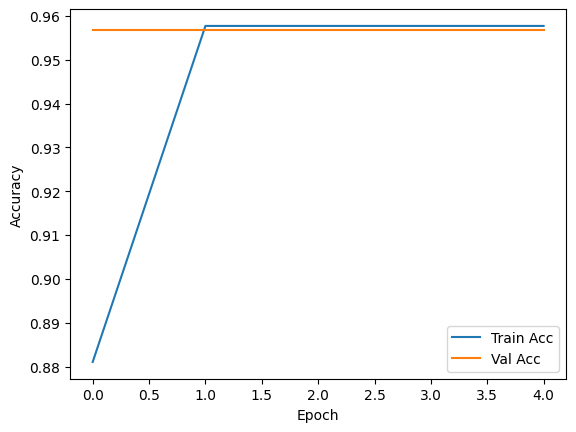

In [60]:
# -------------------------------
# 0. Install dependencies (run once)
# -------------------------------
# !pip install lxml pillow numpy matplotlib tensorflow scikit-learn

# -------------------------------
# 1. Imports
# -------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from lxml import etree
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     RepeatVector, LSTM, Dense, TimeDistributed)

# -------------------------------
# 2. Parameters
# -------------------------------
IMG_SIZE = 128
MAX_LEN = 50   # max token length
BATCH_SIZE = 16
EPOCHS = 5

# -------------------------------
# 3. Parse InkML & Extract Label
# -------------------------------
def parse_inkml(file_path):
    tree = etree.parse(file_path)
    root = tree.getroot()
    
    # Extract strokes
    traces = {}
    for trace in root.findall('{http://www.w3.org/2003/InkML}trace'):
        trace_id = trace.get("id")
        coords = []
        for point in trace.text.strip().split(","):
            xy = point.strip().split(" ")
            if len(xy) >= 2:
                coords.append((float(xy[0]), float(xy[1])))
        traces[trace_id] = coords
    
    # Extract normalizedLabel
    annotation = root.find('{http://www.w3.org/2003/InkML}annotation')
    norm_label = annotation.text if annotation is not None else "unknown"
    
    return traces, norm_label

# -------------------------------
# 4. Convert InkML → Image
# -------------------------------
def inkml_to_image(traces, img_size=IMG_SIZE):
    img = Image.new("L", (img_size, img_size), 255)
    draw = ImageDraw.Draw(img)
    
    all_points = [pt for trace in traces.values() for pt in trace]
    if not all_points:
        return np.array(img)/255.0
    
    xs, ys = zip(*all_points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    for trace in traces.values():
        scaled = [((x-min_x)/(max_x-min_x+1e-5)*img_size,
                   (y-min_y)/(max_y-min_y+1e-5)*img_size) for x, y in trace]
        if len(scaled) > 1:
            draw.line(scaled, fill=0, width=2)
    return np.array(img)/255.0

# -------------------------------
# 5. Load Dataset
# -------------------------------
def load_dataset(inkml_dir, max_samples=None):
    X, Y = [], []
    files = [f for f in os.listdir(inkml_dir) if f.endswith(".inkml")]
    if max_samples:
        files = files[:max_samples]
    for file in files:
        traces, label = parse_inkml(os.path.join(inkml_dir, file))
        img = inkml_to_image(traces)
        X.append(img)
        Y.append(label)
    return np.array(X), Y

data_dir = r"D:\OCR_MATH\mathwriting-2024\train"  # update to your dataset path
X, Y = load_dataset(data_dir, max_samples=500)  # limit for testing

# -------------------------------
# 6. Tokenize Labels
# -------------------------------
tokenizer = Tokenizer(char_level=False, filters='', oov_token='<OOV>')
tokenizer.fit_on_texts(Y)
Y_seq = tokenizer.texts_to_sequences(Y)
Y_seq = pad_sequences(Y_seq, maxlen=MAX_LEN, padding='post')

# Convert X to 4D tensor
X = np.expand_dims(X, -1)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(X, Y_seq, test_size=0.2, random_state=42)
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

num_tokens = len(tokenizer.word_index) + 1

# -------------------------------
# 7. Build CNN + LSTM Model
# -------------------------------
def build_cnn_lstm(img_size=IMG_SIZE, num_tokens=num_tokens, max_len=MAX_LEN):
    inputs = Input(shape=(img_size, img_size,1))
    
    x = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2,2))(x)
    
    # Fix timesteps: GlobalAveragePooling + RepeatVector
    x = GlobalAveragePooling2D()(x)   # (batch, 64)
    x = RepeatVector(max_len)(x)       # (batch, MAX_LEN, 64)
    
    x = LSTM(128, return_sequences=True)(x)
    outputs = TimeDistributed(Dense(num_tokens, activation="softmax"))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

model = build_cnn_lstm()
model.summary()

# -------------------------------
# 8. Train Model
# -------------------------------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=BATCH_SIZE)

# -------------------------------
# 9. Plot Accuracy
# -------------------------------
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [61]:
# -------------------------------
# 1. Function to predict single InkML file
# -------------------------------
def predict_inkml(file_path, model, tokenizer, img_size=IMG_SIZE, max_len=MAX_LEN):
    traces, _ = parse_inkml(file_path)
    img = inkml_to_image(traces)
    img = np.expand_dims(img, axis=(0,-1))  # shape: (1, IMG_SIZE, IMG_SIZE, 1)
    
    pred = model.predict(img)  # (1, MAX_LEN, num_tokens)
    pred_tokens = np.argmax(pred, axis=-1)[0]  # get token IDs
    
    # Convert tokens back to text
    index_word = {v:k for k,v in tokenizer.word_index.items()}
    index_word[0] = ''  # padding token
    predicted_text = ''.join([index_word.get(tok, '') for tok in pred_tokens])
    
    return predicted_text

# -------------------------------
# 2. Example Usage
# -------------------------------
test_file = r"D:\OCR_MATH\sample\0a6d07d9a838a060.inkml"  # replace with a test InkML file
predicted_label = predict_inkml(test_file, model, tokenizer)
print("Predicted LaTeX:", predicted_label)


1/1 [==============================] - 1s 532ms/step
Predicted LaTeX: 


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Reshape, Dense, 
                                     BatchNormalization, Dropout, Embedding, MultiHeadAttention,
                                     LayerNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from glob import glob
import re

In [ ]:
# --- InkML Processing Functions ---
def parse_inkml_traces(inkml_path):
    try:
        tree = ET.parse(inkml_path)
        root = tree.getroot()
    except:
        return []
    traces = []
    for trace in root.findall(XML_NS + "trace"):
        pts = []
        for part in (trace.text or "").strip().split(','):
            coords = part.strip().split()
            if len(coords) >= 2:
                try:
                    pts.append((float(coords[0]), float(coords[1])))
                except:
                    continue
        if pts:
            traces.append(pts)
    return traces

def normalize_and_scale_traces(traces):
    if not traces:
        return []
    xs = [x for tr in traces for x, y in tr]
    ys = [y for tr in traces for x, y in tr]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    width, height = maxx-minx, maxy-miny
    width, height = width if width > 0 else 1, height if height > 0 else 1
    scale = (IMG_SIZE - 2*PADDING) / max(width, height)
    norm = []
    for tr in traces:
        pts = [((x - minx)*scale + PADDING, (y - miny)*scale + PADDING) for x, y in tr]
        norm.append(pts)
    return norm

def render_traces_to_image(traces):
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    for tr in traces:
        if len(tr) == 1:
            x, y = tr[0]
            draw.ellipse([x-STROKE_WIDTH, y-STROKE_WIDTH, x+STROKE_WIDTH, y+STROKE_WIDTH], fill=0)
        else:
            for i in range(1, len(tr)):
                x1, y1 = tr[i-1]
                x2, y2 = tr[i]
                draw.line([x1, y1, x2, y2], fill=0, width=STROKE_WIDTH)
    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr
    return arr

def inkml_to_image_array(path):
    traces = parse_inkml_traces(path)
    if not traces:
        return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    norm = normalize_and_scale_traces(traces)
    return render_traces_to_image(norm)

# --- Tokenization ---
token_pattern = re.compile(r"(\[A-Za-z]+)|([{}^_])|(\d+\.\d+|\d+)|([A-Za-z]+)|([+\-*/=(),\[\].:;%])|(\.)|(\S)", re.VERBOSE)
def tokenize_latex_lite(s):
    if not s:
        return []
    return [m.group(0) for m in token_pattern.finditer(s)]

def normalize_label_for_tokenizer(label):
    if not label or label.strip() == "":
        return PAD_TOKEN
    return f"{START_TOKEN} " + " ".join(tokenize_latex_lite(label)) + f" {END_TOKEN}"

def build_file_label_list(folder):
    files, labels = [], []
    for fp in glob(os.path.join(folder, "*.inkml")):
        try:
            tree = ET.parse(fp)
            root = tree.getroot()
            ann = root.find(XML_NS + "annotation[@type='normalizedLabel']")
            label = ann.text.strip() if ann is not None else ""
        except:
            label = ""
        files.append(fp)
        labels.append(normalize_label_for_tokenizer(label))
    return files, labels

train_files, train_labels = build_file_label_list(TRAIN_DIR)
valid_files, valid_labels = build_file_label_list(VALID_DIR)

train_files, train_labels = train_files[:TRAIN_SUBSET], train_labels[:TRAIN_SUBSET]
valid_files, valid_labels = valid_files[:VALID_SUBSET], valid_labels[:VALID_SUBSET]

print(f"Train size: {len(train_files)}, Valid size: {len(valid_files)}")

tokenizer = Tokenizer(filters='', lower=False, oov_token=VOCAB_OOV_TOKEN, split=' ')
tokenizer.fit_on_texts([START_TOKEN, END_TOKEN, PAD_TOKEN] + train_labels + valid_labels)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary size:", vocab_size)

def encode_label_to_sequence(label):
    seq = tokenizer.texts_to_sequences([label])[0]
    if len(seq) < MAX_OUTPUT_TOKENS:
        seq += [word_index[PAD_TOKEN]] * (MAX_OUTPUT_TOKENS - len(seq))
    else:
        seq = seq[:MAX_OUTPUT_TOKENS]
    return np.array(seq).astype(np.int32)

def gen_example(file_path, label):
    img = inkml_to_image_array(file_path)
    img = np.expand_dims(img, -1).astype(np.float32)
    seq = encode_label_to_sequence(label)
    return img, seq

def tf_load_and_preprocess(path, label):
    img, seq = tf.py_function(func=lambda p, l: gen_example(p.numpy().decode('utf-8'), l.numpy().decode('utf-8')),
                              inp=[path, label],
                              Tout=[tf.float32, tf.int32])
    img.set_shape((IMG_SIZE, IMG_SIZE, 1))
    seq.set_shape((MAX_OUTPUT_TOKENS,))
    return img, seq

def make_training_dataset(files, labels, batch=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 1000))
    ds = ds.map(tf_load_and_preprocess, num_parallel_calls=AUTOTUNE)
    def prepare(img, seq):
        return (img, seq[:-1]), seq[1:]
    ds = ds.map(prepare, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds_tf = make_training_dataset(train_files, train_labels)
valid_ds_tf = make_training_dataset(valid_files, valid_labels, shuffle=False)



In [ ]:
# --- Transformer Decoder Layer ---
def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate):
    inputs_seq = Input(shape=(None, d_model))
    enc_outputs = Input(shape=(None, d_model))

    # Masked self-attention
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(inputs_seq, inputs_seq)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs_seq + attn1)

    # Cross attention
    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(out1, enc_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    # Feed-forward
    ffn = Dense(dff, activation='relu')(out2)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(out2 + ffn)

    return Model([inputs_seq, enc_outputs], output)

In [ ]:

# --- Full Model ---
def build_transformer_model():
    img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(DROPOUT_RATE)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Reshape((IMG_SIZE // 8, (IMG_SIZE // 8) * 128))(x)
    enc_outputs = Dense(TRANSFORMER_DIM, activation='tanh')(x)

    dec_inputs = Input(shape=(MAX_OUTPUT_TOKENS,))
    embedding_layer = Embedding(vocab_size, EMBED_DIM, mask_zero=True)
    dec_emb = embedding_layer(dec_inputs)

    xdec = dec_emb
    for _ in range(NUM_DEC_LAYERS):
        layer = transformer_decoder_layer(TRANSFORMER_DIM, NUM_HEADS, DFF, DROPOUT_RATE)
        xdec = layer([xdec, enc_outputs])

    outputs = Dense(vocab_size, activation='softmax')(xdec)

    model = Model([img_input, dec_inputs], outputs)
    model.compile(optimizer=Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model




In [ ]:
# --- Instantiate and train ---
transformer_model = build_transformer_model()
transformer_model.summary()
transformer_model.fit(train_ds_tf, validation_data=valid_ds_tf, epochs=EPOCHS)
transformer_model.save("math_ocr_transformer_final.h5")
print("Training complete. Model saved as 'math_ocr_final.h5'.")